# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Learning-Basemap" data-toc-modified-id="Learning-Basemap-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Learning Basemap</a></div><div class="lev2 toc-item"><a href="#Surface-Elevation-of-Earth" data-toc-modified-id="Surface-Elevation-of-Earth-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Surface Elevation of Earth</a></div><div class="lev1 toc-item"><a href="#Calculating-Integrated-Atmospheric-Density" data-toc-modified-id="Calculating-Integrated-Atmospheric-Density-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculating Integrated Atmospheric Density</a></div><div class="lev1 toc-item"><a href="#Applying-the-Density-Profile-to-basemap" data-toc-modified-id="Applying-the-Density-Profile-to-basemap-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Applying the Density Profile to basemap</a></div>

# Learning Basemap

A quick run-through to learn how to use the Python basemap visualization kit.

In [110]:
%matplotlib inline
%load_ext version_information

# Standard Library

# Third Party Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from scipy import interpolate
from tqdm import tqdm_notebook as tqdm

# Local Libraries

# Local Definitions
plt.rcParams["font.size"] = 18
GR = np.array([1.,1./1.61803398875])

%version_information matplotlib,numpy,pandas,basemap,scipy

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.1.0
OS Darwin 16.7.0 x86_64 i386 64bit
matplotlib 2.0.2
numpy 1.13.1
pandas 0.20.3
basemap 1.0.7
scipy 0.19.1
Wed Oct 11 10:09:55 2017 MDT

/Users/dolson/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/dolson/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


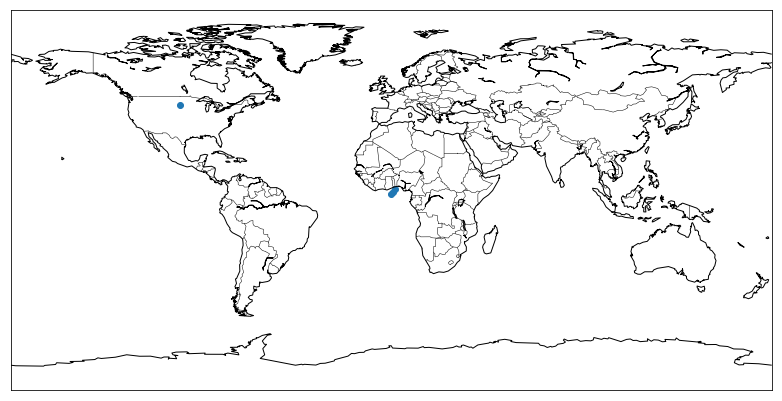

Longitude limits: (-180.0, 180.0)
Latitude limits:  (-90.0, 90.0)


In [2]:
m = Basemap()

fig = plt.figure(figsize=(14,7))
m.scatter(np.array([0,1,2,-100]),np.array([3,4,5,45]))
m.drawcoastlines()
m.drawcountries()
plt.show()
ax = fig.gca()

print("Longitude limits: {0}".format(ax.get_xlim()))
print("Latitude limits:  {0}".format(ax.get_ylim()))



## Surface Elevation of Earth

A lot of space science applications will need to know the surface elevation of Earth. One of the best resources of data for that value is the SRTM: NASA Shuttle Radar Topography Mission. Most recent version of that data (with lots of clean-up and fixes) can be found here:

http://gisweb.ciat.cgiar.org/TRMM/SRTM_Resampled_250m/

Data is provided in ascii files, three different sections of Earth. I've downloaded these locally, because they're awfully big files.

In [3]:
se_head = pd.read_csv("/Volumes/Bravo/SRTM/SRTM_SE_250m_ASC/srtm_se_250m.asc",nrows=6,delim_whitespace=True,header=None,names=["Parameter","Value"])
se_head

,Parameter,Value
0,ncols,100810.000000
1,nrows,28810.000000
2,xllcorner,-30.010417
3,yllcorner,-60.010417
4,cellsize,0.002083
5,NODATA_value,-9999.000000


In [4]:
lon = np.arange(se_head.Value[2],se_head.Value[2]+se_head.Value[0]*se_head.Value[4],se_head.Value[4])
lat = np.arange(se_head.Value[3],se_head.Value[3]+se_head.Value[1]*se_head.Value[4],se_head.Value[4])

In [5]:
se = pd.read_csv("/Volumes/RAM Disk/srtm_se_250m.asc",skiprows=6,nrows=2000,delim_whitespace=True,header=None,engine="c")
#se[se<-100]=np.nan

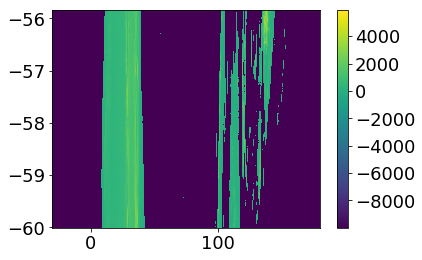

In [6]:
plt.pcolormesh(lon,lat[:2000],se)
plt.colorbar()

**Big Problem**: these files are huge, and it takes forever. May be best to just assume an altitude and calculate to start.

# Calculating Integrated Atmospheric Density

A good table of the density profile as a function of height is found at:
http://www.engineeringtoolbox.com/standard-atmosphere-d_604.html

In [7]:
## There are two tables on this page; the second one is in SI Units.
profile = pd.read_html('http://www.engineeringtoolbox.com/standard-atmosphere-d_604.html')[1].rename(
            columns={'Geo potential Altitude above Sea Level - h - (m)':'Altitude',
                     'Temperature - t - (oC)':'Temperature',
                     'Acceleration of Gravity - g -  (m/s2)':'Gravity',
                     'Absolute Pressure - p - (104 N/m2)':'Pressure',
                     'Density - ρ - (10-1 kg/m3)':'Density',
                     'Dynamic Viscosity - μ - (10-5 N s/m2)':'Viscosity'}).set_index('Altitude')
profile

,Temperature,Gravity,Pressure,Density,Viscosity
Altitude,,,,,
-1000,21.50,9.810,11.390000,13.470000,1.821
0,15.00,9.807,10.130000,12.250000,1.789
1000,8.50,9.804,8.988000,11.120000,1.758
2000,2.00,9.801,7.950000,10.070000,1.726
3000,-4.49,9.797,7.012000,9.093000,1.694
4000,-10.98,9.794,6.166000,8.194000,1.661
5000,-17.47,9.791,5.405000,7.364000,1.628
6000,-23.96,9.788,4.722000,6.601000,1.595
7000,-30.45,9.785,4.111000,5.900000,1.561


(-1000, 90000)

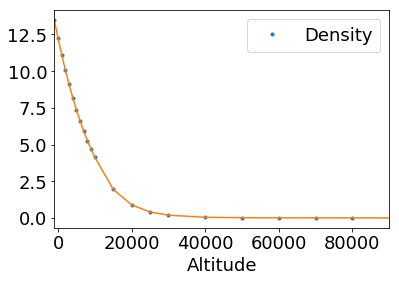

In [8]:
f = interpolate.interp1d(profile.index,profile.Density,fill_value='extrapolate')
x = np.arange(-1000,90000,100)
plt.figure(figsize=(14,7))
profile.plot(y='Density',style='.')
plt.plot(x,f(x))
plt.xlim([-1000,90000])

In [9]:
hmax = 82867.795
f(80000),f(hmax)

(array(0.00018460000000000004), array(3.585000016032708e-11))

This value marks the boundary; the density should be hard-coded to zero beyond it, as the extrapolation would otherwise go negative.

In [10]:
def density(h):
    profile = pd.read_html('http://www.engineeringtoolbox.com/standard-atmosphere-d_604.html')[1]
    hmax = 82867.795
    f = interpolate.interp1d(profile['Geo potential Altitude above Sea Level - h - (m)'],profile['Density - ρ - (10-1 kg/m3)'],fill_value='extrapolate')
    rho = f(h)
    rho[h>hmax] = 0.
    return rho

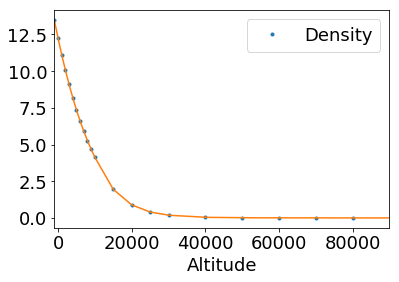

In [11]:
profile.plot(y='Density',style='.')
plt.plot(x,density(x))
plt.xlim(x.min(),x.max());

Not a bad little model! This should do nicely. Now to set up a function to provide the height along a specified path.

In [151]:
def pathDensity(startloc, stoploc, dl=1, verbose=False):
    try:
        if len(startloc)<3 or len(stoploc)<3:
            raise TypeError("Start and Stop locations need to be in three dimensions.")
    except:
        raise TypeError("Start and Stop locations need to be in three dimensions.")
    
    stlat_check = np.isnan(startloc[0]) or -90<startloc[0]<90
    splat_check = np.isnan(stoploc[0]) or -90<stoploc[0]<90
    stlon_check = np.isnan(startloc[1]) or -180<startloc[1]<=180
    splon_check = np.isnan(stoploc[1]) or -180<stoploc[1]<=180
    stalt_check = startloc[2]>=10000
    spalt_check = stoploc[2]>=10000
    
    if not stlat_check or not splat_check:
        raise ValueError("Start and Stop latitudes must be between -90 and 90.")
    if not stlon_check or not splon_check:
        raise ValueError("Start and Stop longitudes must be between -180 and 180.")
    if not stalt_check or not spalt_check:
        raise ValueError("Start and Stop altitudes must be above 10000.")
    
    if np.isnan(startloc).any() or np.isnan(stoploc).any():
        return np.nan
    
    if verbose:
        print("Calculating Path Density from {0[0]} deg Latitude, {0[1]} deg Longitude, {0[2]} m Altitude".format(startloc))
        print("    to {0[0]} deg Latitude, {0[1]} deg Longitude, {0[2]} m Altitude".format(stoploc))
    
    start = np.array([startloc[2]*np.sin((90-startloc[0])*np.pi/180)*np.cos(startloc[1]*np.pi/180),
                      startloc[2]*np.sin((90-startloc[0])*np.pi/180)*np.sin(startloc[1]*np.pi/180),
                      startloc[2]*np.cos((90-startloc[0])*np.pi/180)])
    stop  = np.array([stoploc[2]*np.sin((90-stoploc[0])*np.pi/180)*np.cos(stoploc[1]*np.pi/180),
                      stoploc[2]*np.sin((90-stoploc[0])*np.pi/180)*np.sin(stoploc[1]*np.pi/180),
                      stoploc[2]*np.cos((90-stoploc[0])*np.pi/180)])
    
    ### Not sure why, but the number of points that gives a separation
    #   no larger than dl is N = L//dl + 2
    L = np.sqrt(sum((stop-start)**2))
    N = int(L/dl)+2           
    x = np.linspace(start[0],stop[0],N)
    y = np.linspace(start[1],stop[1],N)
    z = np.linspace(start[2],stop[2],N)
    #   Actual segment length
    dla = np.sqrt((x[1]-x[0])**2+(y[1]-y[0])**2+(z[1]-z[0])**2)
    
    ### OK, now I've got my path to integrate along. We need the altitude
    #   along that path.
    h = np.sqrt(x**2+y**2+z**2)
    rho = density(h)
    
    ### Path Density
    if verbose:
        print("Integrating density")
    sigma = sum((rho[:-1]+rho[1:])/2*dla)
    return sigma    

[1.3962634015954636, 0.5235987755982988, 20000.0]
[1.5707963267948966, 1.5707963267948966, 100000.0]

[ 17057.37063905   9848.07753012   3472.96355334]
[  6.12323400e-12   1.00000000e+05   6.12323400e-12]

91817.1252761
0.999990473285

5208116124.09


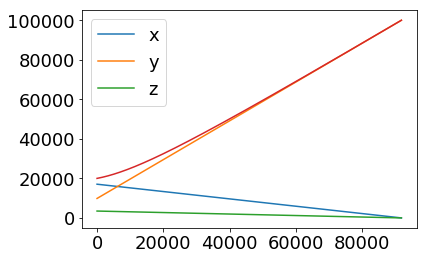

In [152]:
stlat = (90-10)*np.pi/180
stlon = 30*np.pi/180
stalt = 20000.
splat = (90-0)*np.pi/180
splon = 90*np.pi/180
spalt = 100000.
print([stlat,stlon,stalt])
print([splat,splon,spalt])
print()
start = np.array([stalt*np.sin(stlat)*np.cos(stlon),
                  stalt*np.sin(stlat)*np.sin(stlon),
                  stalt*np.cos(stlat)])
stop = np.array([spalt*np.sin(splat)*np.cos(splon),
                 spalt*np.sin(splat)*np.sin(splon),
                 spalt*np.cos(splat)])
print(start)
print(stop)
print()

L = np.sqrt(sum((stop-start)**2))
print(L)

dl = 1.
N = int(L/dl)+2
x = np.linspace(start[0],stop[0],N)
y = np.linspace(start[1],stop[1],N)
z = np.linspace(start[2],stop[2],N)
dla = np.sqrt((x[1]-x[0])**2+(y[1]-y[0])**2+(z[1]-z[0])**2)
print(dla)
print()
plt.plot(x)
plt.plot(y)
plt.plot(z)
plt.legend(['x','y','z'])

h=np.sqrt(x**2+y**2+z**2)
plt.plot(h)
Iden = sum((h[1:]+h[:-1])/2.*dla)
print(Iden);

[1.3962634015954636, 0.17453292519943295, 20000.0]
[1.5707963267948966, 1.5707963267948966, 100000.0]

[ 19396.92620786   3420.20143326   3472.96355334]
[  6.12323400e-12   1.00000000e+05   6.12323400e-12]

98569.5678866
0.999995616177

5369006618.7


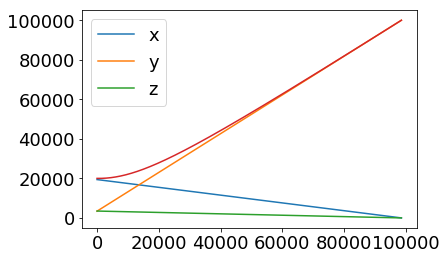

In [153]:
stlat = (90-10)*np.pi/180
stlon = 10*np.pi/180
stalt = 20000.
splat = (90-0)*np.pi/180
splon = 90*np.pi/180
spalt = 100000.
print([stlat,stlon,stalt])
print([splat,splon,spalt])
print()
start = np.array([stalt*np.sin(stlat)*np.cos(stlon),
                  stalt*np.sin(stlat)*np.sin(stlon),
                  stalt*np.cos(stlat)])
stop = np.array([spalt*np.sin(splat)*np.cos(splon),
                 spalt*np.sin(splat)*np.sin(splon),
                 spalt*np.cos(splat)])
print(start)
print(stop)
print()

L = np.sqrt(sum((stop-start)**2))
print(L)

dl = 1.
N = int(L/dl)+2
x = np.linspace(start[0],stop[0],N)
y = np.linspace(start[1],stop[1],N)
z = np.linspace(start[2],stop[2],N)
dla = np.sqrt((x[1]-x[0])**2+(y[1]-y[0])**2+(z[1]-z[0])**2)
print(dla)
print()
plt.plot(x)
plt.plot(y)
plt.plot(z)
plt.legend(['x','y','z'])

h=np.sqrt(x**2+y**2+z**2)
plt.plot(h)
Iden = sum((h[1:]+h[:-1])/2.*dla)
print(Iden);

In [154]:
pathDensity((0,0,10000),(0,0,20000),verbose=True)

Calculating Path Density from 0 deg Latitude, 0 deg Longitude, 10000 m Altitude
    to 0 deg Latitude, 0 deg Longitude, 20000 m Altitude
Integrating density


22300.250028212289

Well, we have a result; is it right? I purposely set the test to be a directly radial path so that I can calculate the integral directly.

In [155]:
x = np.linspace(10000,20000,100001)
rho = density(x)
np.trapz(rho,x)

22300.25

Looks good! Now we're set up.

# Applying the Density Profile to basemap

* Observer at (0$^\circ$ lat, 0$^\circ$ lon, 100 km)
* Source altitude 20,000 m

/Users/dolson/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


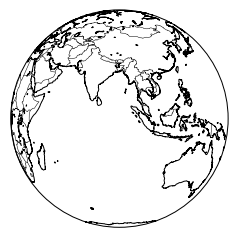

In [157]:
m = Basemap(projection='geos',lon_0=90,resolution='l')
m.drawcoastlines()
m.drawcountries()

In [160]:
gX,gY = m.makegrid(nx=120,ny=100)
gX[gX==1e30]=np.nan
gY[gY==1e30]=np.nan
Iden = np.zeros_like(gX)
start = np.array([0.,0.,20000.])
stop  = np.array([0.,90.,100000.])
for i in tqdm(range(gX.shape[0])):
    for j in range(gY.shape[1]):
        start[1] = gX[i,j]
        start[0] = gY[i,j]
        Iden[i,j] = pathDensity(start,stop)

A Jupyter Widget

In [181]:
Iden

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ..., 
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

/Users/dolson/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/dolson/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/dolson/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


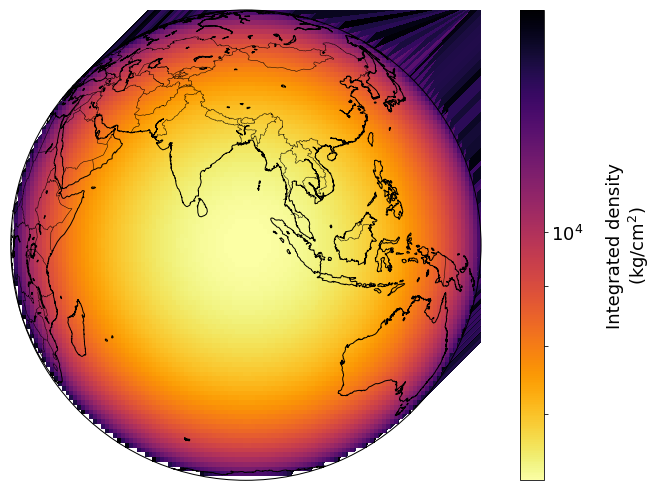

In [182]:
gX,gY = m.makegrid(nx=120,ny=100)
x,y = m(gX,gY)
levels = mpl.ticker.MaxNLocator(nbins=7).tick_values(0,Iden.max())
cmap = plt.get_cmap('inferno_r')
plt.figure(figsize=14*GR)
m.pcolormesh(x,y,Iden,cmap=cmap,norm=LogNorm())#,norm=BoundaryNorm(levels, ncolors=cmap.N, clip=True))
m.drawcoastlines()
m.drawcountries()
parallels = np.arange(-80.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
meridians = np.arange(0.,180.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
plt.colorbar(label="\nIntegrated density\n(kg/cm$^2$)")

/Users/dolson/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/dolson/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/dolson/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


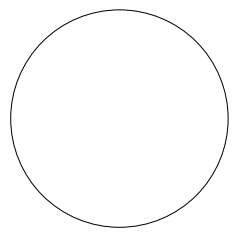

In [183]:
m.contourf(gX,gY,Iden)

In [178]:
m.contourf?